In [24]:
# import numpy, scipy, and matplotlib
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
%matplotlib widget

import os
import tempfile
import datetime

# torch random seed
torch.manual_seed(0)

# PINN trained with Learning Schedule

Experimentally is seems difficult to train the PINN for a period of time $T \sim \frac{1}{\lambda}$ where $\lambda$ is the Lypanov exponent. We think that this is because when $T$, the time span where we calculate the loss_ode, is bigger than the tipycal Lyupanov time, there is the risk that the network "fail" for just few point, falling on another legal trajectory for the ode, but not the same one of the IC. 

We try to mitigate the problem training the network with a Learning Schedule.

- We provide to the loss function point only until $t+n \Delta t$ where $\Delta t << \frac{1}{\lambda} $, starting with n=1.

- Then we train the net until the loss is lower than a certian trashold $p$ (as precision) and we add one point to the loss function as timespan is augmented to $n\rightarrow n+1$.

This method has only two hyperparameter, $\Delta t$, which have to respect the condition $\Delta t << \frac{1}{\lambda}$, and the trashold precision $p$.

Since this method can be computationally expensive, some checkpoint method and the possibility to restore and train the network in more session will be implemented.

## Useful func

In [25]:
def lorenz(t, Y):
    # documentation
    """
    This function returns the right-hand side of the Lorenz system of ordinary differential equations.
    Parameters:
    t (float): time
    Y (array): state vector [x, y, z]

    Returns:
    array: [dxdt, dydt, dzdt]
    """

    x, y, z = Y
    dxdt = 10 * (y - x)
    dydt = x * (28 - z) - y
    dzdt = x * y - 8/3 * z

    return [dxdt, dydt, dzdt]


# define seq_lorenz, where not asking t, but the input is a numpy array of Y's and output is a numpy array of dY_dt's
def seq_lorenz(Y):
    # documentation
    """
    This function returns the right-hand side of the Lorenz system of ordinary differential equations.
    Parameters:
    Y (array): state vector [x, y, z]

    Returns:
    array: [dxdt, dydt, dzdt]
    """

    x, y, z = Y[:, 0], Y[:, 1], Y[:, 2]
    dxdt = 10 * (y - x)
    dydt = x * (28 - z) - y
    dzdt = x * y - 8/3 * z

    return np.array([dxdt, dydt, dzdt]).T

In [26]:
def plot_components(X, Y):
    """
    This function plots the components of the state vector Y as a function of time X.
    """
    plt.figure(figsize=(15, 10))
    plt.subplot(131)
    plt.plot(X, Y[:,0], label='x')
    plt.ylabel('x')
    plt.xlabel('time')
    plt.grid()

    # do all the same for y
    plt.subplot(132)
    plt.plot(X, Y[:,1], label='y')
    plt.ylabel('y')
    plt.xlabel('time')
    plt.grid()

    # do all the same for z
    plt.subplot(133)
    plt.plot(X, Y[:,2], label='z')
    plt.ylabel('z')
    plt.xlabel('time')
    plt.grid()



def plot_compare_components(X, Y, Y_pred):
    """
    This function plots the components of the state vector Y and Y_pred as a function of time X.
    """
    plt.figure(figsize=(15, 10))
    plt.subplot(131)
    plt.plot(X, Y[:,0], label='x')
    plt.plot(X, Y_pred[:,0], label='x_pred')
    plt.ylabel('x')
    plt.xlabel('time')
    plt.legend()
    plt.grid()

    # do all the same for y
    plt.subplot(132)
    plt.plot(X, Y[:,1], label='y')
    plt.plot(X, Y_pred[:,1], label='y_pred')
    plt.ylabel('y')
    plt.xlabel('time')
    plt.legend()
    plt.grid()

    # do all the same for z
    plt.subplot(133)
    plt.plot(X, Y[:,2], label='z')
    plt.plot(X, Y_pred[:,2], label='z_pred')
    plt.ylabel('z')
    plt.xlabel('time')
    plt.legend()
    plt.grid()



# def show history
def show_history(history):
    """ 
    # plot history loss and lr in two subplots
    """
    
    history = np.array(history)
    fig, ax = plt.subplots(figsize=(15, 10))

    ax.plot(history[:, 0],history[:, 1], label='loss')
    ax.legend(loc='upper left')
    ax.set_yscale('log')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    plt.grid()

    # plot the learning rate
    ax2 = ax.twinx()
    ax2.plot(history[:, 0], history[:, -1], label='n_points', color='r')
    ax2.set_yscale('log')
    ax2.set_ylabel('lr')
    # legend to the right
    ax2.legend(loc='upper right')
    plt.grid()
    plt.title('PINN history')

    # new plot losses
    plt.figure(figsize=(15, 10))
    plt.plot(history[:, 0], history[:, 1], label='loss')
    plt.plot(history[:, 0], history[:, 2], label='loss_ode')
    plt.plot(history[:, 0], history[:, 3], label='loss_ic')
    plt.legend()
    plt.yscale('log')

    # history to list
    history = history.tolist()

    

## Load data

In [27]:
# import data
# data are generated by "src/DHOscillator_data_gen.py"
data = np.load('../data/Lorenz_data.npy')
# Y is the state, X is the time, Y is made of x, y, z
X = data[:,0]
Y = data[:,1:]

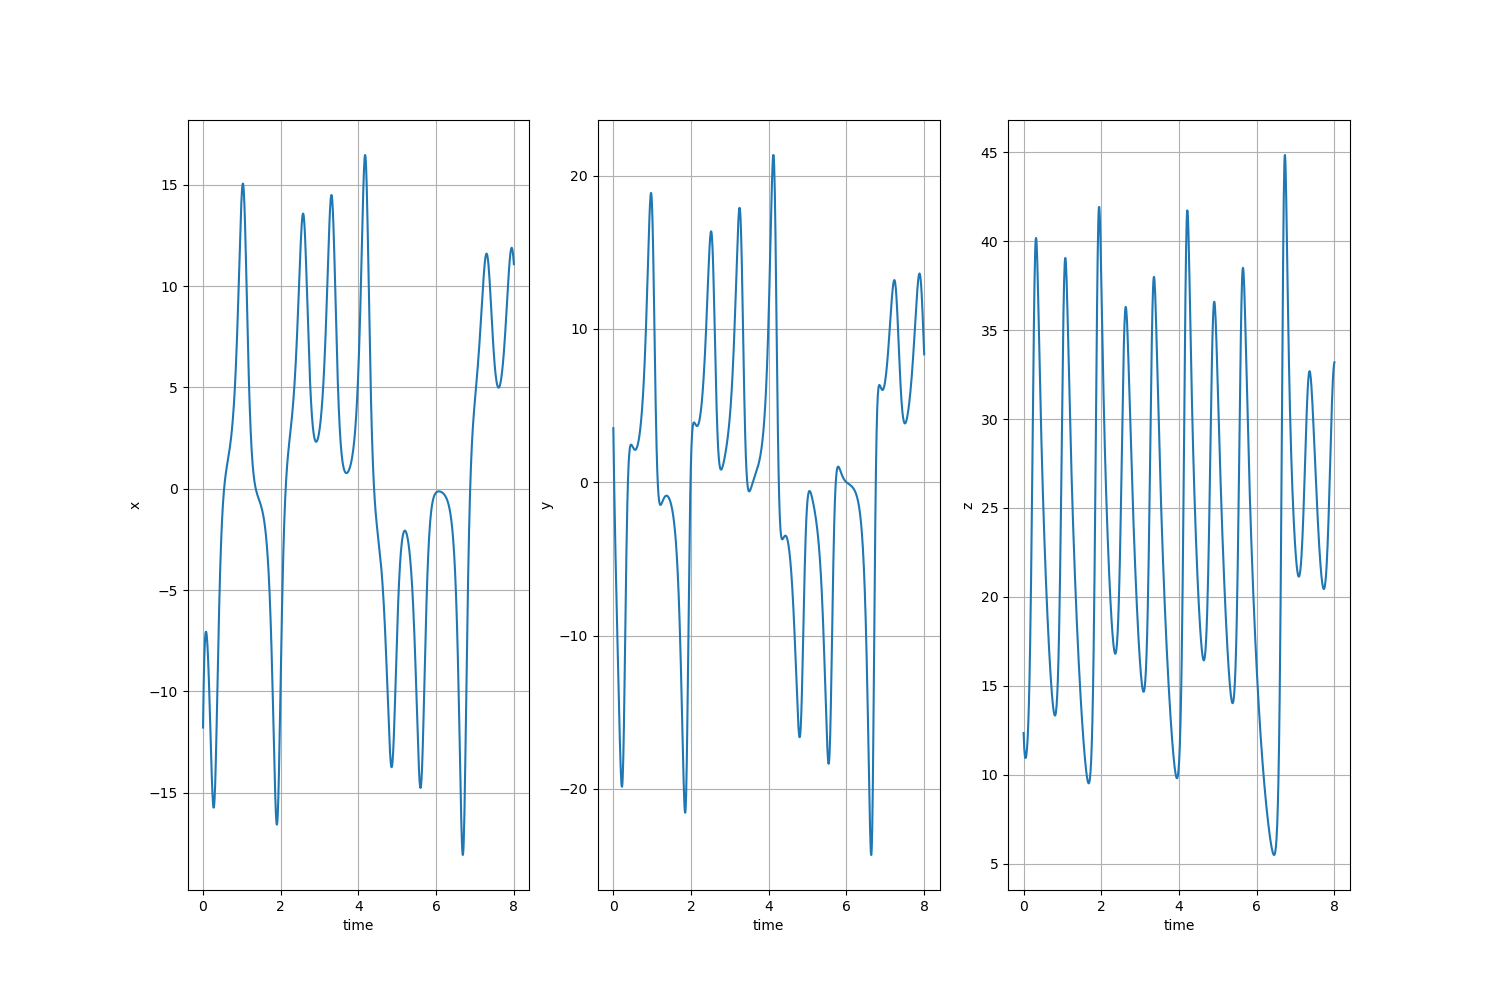

In [28]:
# plot components
plot_components(X, Y)

## Define the model
This is inspired by the tuned model on DHO

In [29]:
# Model class
class FFNN(torch.nn.Module):
    def __init__(self, n_layers, n_neurons):
        super(FFNN, self).__init__()
        layers = []
        for i in range(n_layers):
            if i == 0:
                layers.append(torch.nn.Linear(1, n_neurons))
            else:
                layers.append(torch.nn.Linear(n_neurons, n_neurons))
            layers.append(torch.nn.Tanh())
        layers.append(torch.nn.Linear(n_neurons, 3))
        self.model = torch.nn.Sequential(*layers)
    def forward(self, x):
        return self.model(x)

## The PINN Learning Schedule class
Here we define the class that will train the network with the learning schedule described above.

In [30]:

class PINN_LearningSchedule:
    # write documentation
    """
    This class implements the learning schedule for the PINN model.
    """
    
    def __init__(self, experiment_folder, experiment_name, 
                 precision=None, n_points_checkpoint=1, model=None):
        """
        This function initializes the class.
        Checks if the experiment folder exists, if not, creates it.

        Parameters:
        experiment_folder (str): path to the experiment folder
        experiment_name (str): name of the experiment
        precision (float): precision hyperparameter
        n_points_checkpoint (int): number of points to save the model
        model (torch.nn.Module): model to train
        """
        self.experiment_folder = experiment_folder
        self.experiment_name = experiment_name

        self.n_points_checkpoint = n_points_checkpoint
        self.precision = precision

        self.X = None
        self.Y = None

        # if experiment folder does not exist, create it
        if not os.path.exists(experiment_folder):
            os.makedirs(experiment_folder)
            self.experiment_folder = experiment_folder
            self.model = model

            self.n_points = 1
            self.history =[]
            self.epochs = 0

            # print start new experiment
            print('Start new experiment: ', experiment_folder)

        # if experiment folder exists, load the last model
        else:
            self.experiment_folder = experiment_folder

            # get the last model
            list_files = [f for f in os.listdir(experiment_folder) if f.endswith('.pt')]
            number_of_points = [f.split('_')[-1] for f in list_files]
            number_of_points = [f.split('.')[0] for f in number_of_points]
            number_of_points = [int(f) for f in number_of_points]
            max_index = number_of_points.index(max(number_of_points))
            self.n_points = max(number_of_points)

            # load the last model and history
            self.model = torch.load(os.path.join(experiment_folder, list_files[max_index]))
            self.history = np.load(os.path.join(experiment_folder, list_files[max_index].split('.')[0] + '_history.npy'))
            self.epochs = self.history[-1, 0]
            self.history = self.history.tolist()
            # get epochs

            # print load existing experiment, gives the number of points
            print('Load existing experiment: ', experiment_folder, ' with ', self.n_points, ' points', ' and ', self.epochs, ' epochs')

        
    def load_data(self, X, Y):
        """
        This function loads the data to the class.
        """
        self.X = X
        self.Y = Y


    def train(self, max_lr, min_lr, patience=700, factor=0.7):
        """
        This function trains the model using the learning schedule.
        """

        optimizer = torch.optim.Adam(self.model.parameters(), lr=max_lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=factor, patience=patience, min_lr=min_lr)
        loss_fn = torch.nn.MSELoss()  

        while True:
            while True:

                # cut the data to n_points
                X_temp = self.X[:self.n_points]
                Y_temp = self.Y[:self.n_points]

                # convert to torch tensor
                X_temp = torch.tensor(X_temp, dtype=torch.float32).view(-1, 1)
                Y_temp = torch.tensor(Y_temp, dtype=torch.float32)


                #---------------------------------------------------------------------------------------------------------------------
                # PINN training
                # Train the model using the PINN loss 
                # for one epoch
                #---------------------------------------------------------------------------------------------------------------------
                
                # train the model
                optimizer.zero_grad()
                X_temp.requires_grad = True
                Y_pred = self.model(X_temp)

                # get the derivatives
                dx_dt_pred = torch.autograd.grad(Y_pred[:,0], X_temp, grad_outputs=torch.ones_like(Y_pred[:,0]), create_graph=True)[0]
                dy_dt_pred = torch.autograd.grad(Y_pred[:,1], X_temp, grad_outputs=torch.ones_like(Y_pred[:,1]), create_graph=True)[0]
                dz_dt_pred = torch.autograd.grad(Y_pred[:,2], X_temp, grad_outputs=torch.ones_like(Y_pred[:,2]), create_graph=True)[0]

                # get true derivatives, using the lorenz parameter
                dx_dt_ode = 10 * (Y_pred[:,1] - Y_pred[:,0])
                dy_dt_ode = Y_pred[:,0] * (28 - Y_pred[:,2]) - Y_pred[:,1]
                dz_dt_ode = Y_pred[:,0] * Y_pred[:,1] - 8/3 * Y_pred[:,2]

                # loss ode
                loss_ode = loss_fn(dx_dt_pred[:,0], dx_dt_ode) + loss_fn(dy_dt_pred[:,0], dy_dt_ode) + loss_fn(dz_dt_pred[:,0], dz_dt_ode)

                # add loss ic
                loss_ic = torch.mean((Y_pred[0] - Y_temp[0])**2)

                loss = 20*loss_ode + loss_ic

                loss.backward()
                optimizer.step()
                scheduler.step(loss)
                #---------------------------------------------------------------------------------------------------------------------
                

                self.epochs += 1

                
                # save history
                if self.epochs % 1000 == 0:
                    self.history.append([self.epochs, loss.item(), loss_ode.detach().numpy(), loss_ic.detach().numpy(), optimizer.param_groups[0]["lr"], self.n_points])
                    print(f'N_points, {self.n_points}, Epoch {self.epochs}, Loss {loss.item()}, lr {optimizer.param_groups[0]["lr"]}')

                # check loss, if less than precision, break and n_points + 1
                if loss < self.precision:
                    break

            # save the model at n_points_checkpoint
            if self.n_points % self.n_points_checkpoint == 0:
                date = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
                torch.save(self.model, os.path.join(self.experiment_folder, f'{self.experiment_name}_{date}_{self.n_points}.pt'))
                # print model saved
                print('Model saved at ', os.path.join(self.experiment_folder, f'{self.experiment_name}_{date}_{self.n_points}.pt'))
                # save history
                np.save(os.path.join(self.experiment_folder, f'{self.experiment_name}_{date}_{self.n_points}_history.npy'), self.history)
            
            # if num_pint equal total number of points, break
            if self.n_points == len(self.X):
                # print end of experiment
                print('End of experiment, reached the end of the data')
                break
            
            # increase n_points
            self.n_points = self.n_points + 1

            # restart lr scheduler
            optimizer = torch.optim.Adam(self.model.parameters(), lr=max_lr)
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=factor, patience=patience, min_lr=min_lr)

    def get_history(self):
        return self.history


## Example of usage
Here we present an example of a new experiment, one define the architecture, the precision and start a new training session.

In [31]:
# folder name ../lorenz_PINN_widehale
# experiment name lorenz
# precision 0.01
# max_lr 1e-5
# min_lr 1e-6

experiment_folder = '../models/lorenz_PINN_widewhale'
experiment_name = 'lorenz_PINN_widewhale'
precision = 0.01
max_lr = 1e-3
min_lr = 1e-6

n_layers = 7
n_neurons = 100

widewhale_model = FFNN(n_layers, n_neurons)

In [32]:
widewhale_PINN_LS = PINN_LearningSchedule(experiment_folder, experiment_name, precision=precision, model=widewhale_model)
widewhale_PINN_LS.load_data(X, Y)
widewhale_PINN_LS.train(max_lr, min_lr)

Start new experiment:  ../models/lorenz_PINN_widewhale


KeyboardInterrupt: 

## Shortbow experiment
Starting with the best hyperparameter and architecture found in the DHO case, we try to train the network with the learning schedule for some days (on this computer). This section will load the resulting model.

In [33]:
# load experiment, folder name ../lorenz_PINN_shortbow

experiment_folder = '../models/lorenz_PINN_shortbow'
experiment_name = 'lorenz'

shortbow_PINN_LS = PINN_LearningSchedule(experiment_folder, experiment_name)

Load existing experiment:  ../models/lorenz_PINN_shortbow  with  120  points  and  26094000.0  epochs


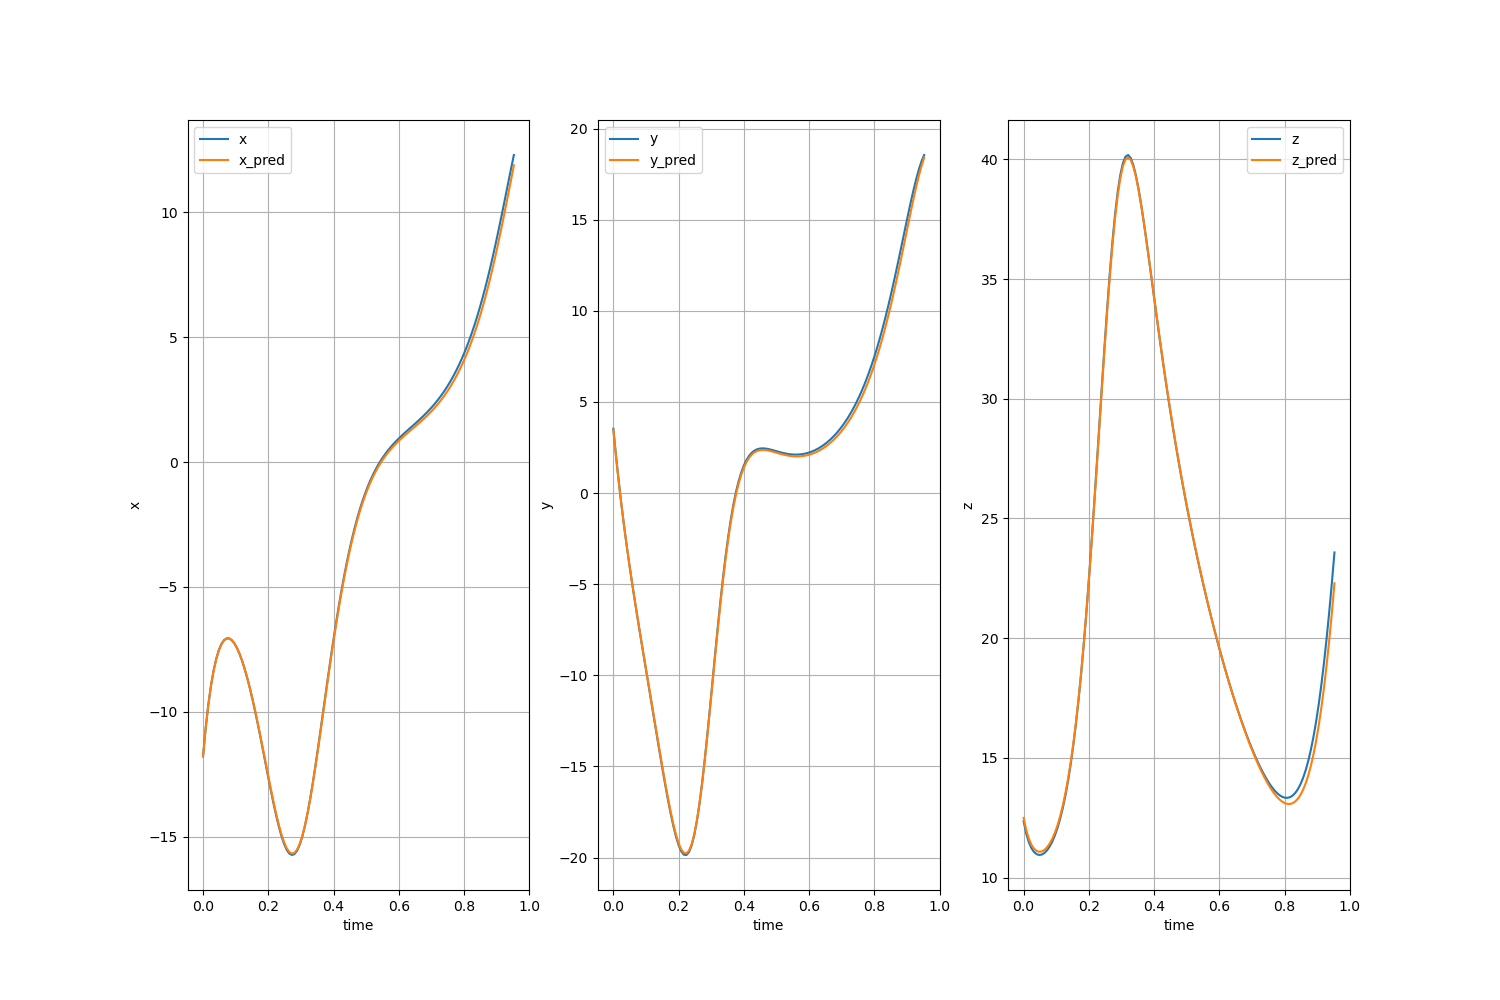

In [34]:
# show results
X_temp = X[:shortbow_PINN_LS.n_points]
Y_temp = Y[:shortbow_PINN_LS.n_points]

Y_pred = shortbow_PINN_LS.model(torch.tensor(X_temp, dtype=torch.float32).view(-1, 1)).detach().numpy()
# show results
plot_compare_components(X_temp, Y_temp, Y_pred)